In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}


<IPython.core.display.Javascript object>

In [2]:


import cv2
import gtsam
import numpy as np
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
from scipy.spatial.transform import Rotation as R
import gtsam.utils.plot as gtsam_plot
from warnings import warn
import rospy
from std_msgs.msg import Header
from geometry_msgs.msg import PoseStamped, Point
from sensor_msgs.msg import PointCloud2, PointField
from sensor_msgs import point_cloud2 as pc2
import struct
from nav_msgs.msg import Path
import itertools

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider
import ipywidgets as widgets
from IPython.display import display



plt.rcParams['figure.figsize'] = [20, 10]


In [2]:
# rospy.init_node('triangulate_test', anonymous=True)

In [3]:
def f(x):
    return x

interact(f, x=10, y=12);



interactive(children=(IntSlider(value=10, description='x', max=30, min=-10), Output()), _dom_classes=('widget-…

In [3]:
def sample_spherical(n):

    phi = np.linspace(0, np.pi, n)
    theta = np.linspace(0, 2 * np.pi, n)
    x = np.outer(np.sin(theta), np.cos(phi)).flatten()
    y = np.outer(np.sin(theta), np.sin(phi)).flatten()
    z = np.outer(np.cos(theta), np.ones_like(phi)).flatten()
    points_3d = np.vstack((y, z, x, np.ones(n**2)))
    points_3d *= 30
    return points_3d

points_3d = sample_spherical(15)

def draw_sphere(n=15):
    points_3d = sample_spherical(n)
#     plt.rcParams['legend.fontsize'] = 10

    fig = plt.figure(figsize=plt.figaspect(1))
    ax = fig.gca(projection='3d')

    ax.scatter(points_3d[2], points_3d[0], points_3d[1], marker='o')
    ax.legend()

    return plt
    
interact(draw_sphere, n=(0,25,1))

interactive(children=(IntSlider(value=15, description='n', max=25), Output()), _dom_classes=('widget-interact'…

<function __main__.draw_sphere(n=15)>

In [6]:
roll = FloatSlider(min=-np.pi, max=np.pi, step=0.1, value=0.0, description="roll")
pitch = FloatSlider(min=-np.pi, max=np.pi, step=0.1, value=0.0, description="pitch")
yaw = FloatSlider(min=-np.pi, max=np.pi, step=0.1, value=0.0, description="yaw")
rot = widgets.HBox([roll, pitch, yaw])
x = FloatSlider(min=-12, max=12, step=0.2, value=0.0, description="x")
y = FloatSlider(min=-12, max=12, step=0.2, value=0.0, description="y")
z = FloatSlider(min=-12, max=12, step=0.2, value=-5.0, description="z")
noise = FloatSlider(min=0., max=1.2, step=0.02, value=0.0, description="noise")
t = widgets.HBox([x, y, z])
ui = widgets.VBox([rot, t, noise])

fx, fy = 100.0, 100.0
cx, cy = 200.0, 150.0
s = 0.
width, height = 400, 300
    
def project(roll=0.,pitch=0.,yaw=0.,x=0.,y=0.,z=-0.,noise=0.):
    intrinsic = np.array([
        [fx,  s, cx],
        [0., fy, cy],
        [0., 0., 1.]
    ])


    extrinsic = np.hstack((R.from_rotvec((roll, pitch, yaw)).as_matrix(), np.array([x, y, z])[:, np.newaxis]))
    projection = intrinsic @ extrinsic

    points_2d = projection@points_3d
    points_2d = points_2d[:2] / points_2d[2]
    points_2d += np.random.normal(scale=noise, size=points_2d.shape)
    return points_2d, projection

def project_and_plot(roll=0.,pitch=0.,yaw=0.,x=0.,y=0.,z=-0.,noise=0.):
    points_2d, _ = project(roll, pitch, yaw, x, y, z,noise)
    plt.figure(figsize=plt.figaspect(height/width))
    plt.xlim([0,width])
    plt.ylim([0,height])
    plt.scatter(points_2d[0], points_2d[1])
    return plt
    
out = widgets.interactive_output(project_and_plot, 
                                 {"roll":roll,"pitch":pitch,"yaw":yaw,"x":x,"y":y,"z":z,"noise":noise})
out.layout.height = '600px'
display(ui, out)

Output(layout=Layout(height='600px'))

In [51]:
norm(-5)

-6.868635107630058

<module 'matplotlib.pyplot' from '/usr/lib/python3/dist-packages/matplotlib/pyplot.py'>

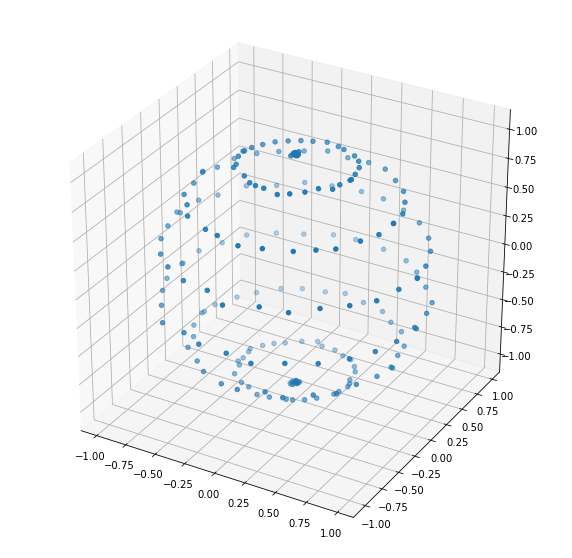

In [76]:
from gtsam.utils import plot

norm = np.random.normal
L = gtsam.symbol_shorthand.L
X = gtsam.symbol_shorthand.X
K = gtsam.Cal3_S2(fx, fy, s, cx, cy)


frames = [(X(i), project(roll=norm(),pitch=norm(),yaw=norm(),x=norm(),y=0.,z=norm(-5), noise=.3)) for i in range(8)]
_, (kps1, proj1) = frames[0]
_, (kps2, proj2) = frames[1]
rp_h = cv2.triangulatePoints(proj1, proj2, kps1, kps2)
rp_3d = rp_h[:3] / rp_h[3]

fig = plt.figure(figsize=plt.figaspect(1))
ax = fig.gca(projection='3d')

ax.scatter(rp_3d[2], rp_3d[0], rp_3d[1], marker='o')

plt

In [77]:

# Define the camera observation noise model
measurement_noise = gtsam.noiseModel.Isotropic.Sigma(2, 1.0)  # one pixel in u and v

# Create a factor graph
graph = gtsam.NonlinearFactorGraph()



# Add a prior on pose x1. This indirectly specifies where the origin is.
# 0.3 rad std on roll,pitch,yaw and 0.1m on x,y,z
pose_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.3, 0.3, 0.3, 0.1, 0.1, 0.1]))
x0, (_, proj0) = frames[0]
factor = gtsam.PriorFactorPose3(x0, gtsam.Pose3(proj0), pose_noise)
graph.push_back(factor)

# Simulated measurements from each camera pose, adding them to the factor graph

for x_symbol, (kps, proj) in frames:
    for j, kp in enumerate(kps.T):
        factor = gtsam.GenericProjectionFactorCal3_S2(
            kp, measurement_noise, x_symbol, L(j), K)
        graph.push_back(factor)
        
point_noise = gtsam.noiseModel.Isotropic.Sigma(3, 0.1)
factor = gtsam.PriorFactorPoint3(L(0), points_3d[:3,0], point_noise)
graph.push_back(factor)
graph.print_('Factor Graph:\n')

initial_estimate = gtsam.Values()
for x_symbol, (kps, proj) in frames:
    transformed_pose = gtsam.Pose3(proj).retract(0.1*np.random.randn(6,1))
    initial_estimate.insert(x_symbol, transformed_pose)
for j, point in enumerate(rp_3d.T):
    transformed_point = gtsam.Point3(point)# + 0.1*np.random.randn(3)
    initial_estimate.insert(L(j), transformed_point)
    
    
params = gtsam.DoglegParams()
params.setVerbosity('TERMINATION')
optimizer = gtsam.DoglegOptimizer(graph, initial_estimate, params)
print('Optimizing:')
result = optimizer.optimize()
result.print_('Final results:\n')
print('initial error = {}'.format(graph.error(initial_estimate)))
print('final error = {}'.format(graph.error(result)))

marginals = gtsam.Marginals(graph, result)
plot.plot_3d_points(1, result, marginals=marginals)
plot.plot_trajectory(1, result, marginals=marginals, scale=8)
plot.set_axes_equal(1)
plt.show()

Optimizing:


RuntimeError: 
Indeterminant linear system detected while working near variable
8646911284551352327 (Symbol: x7).

Thrown when a linear system is ill-posed.  The most common cause for this
error is having underconstrained variables.  Mathematically, the system is
underdetermined.  See the GTSAM Doxygen documentation at
http://borg.cc.gatech.edu/ on gtsam::IndeterminantLinearSystemException for
more information.

<module 'matplotlib.pyplot' from '/usr/lib/python3/dist-packages/matplotlib/pyplot.py'>

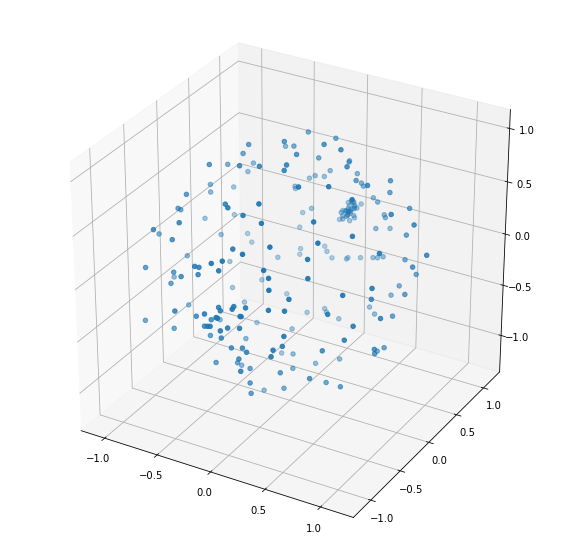

In [69]:
x, y, z = np.array([result.atPoint3(L(i)) for i in range(points_3d.shape[1])]).T
fig = plt.figure(figsize=plt.figaspect(1))
ax = fig.gca(projection='3d')

ax.scatter(x, y, z, marker='o')

plt